# Stastical Models Trained on the Seeds Data Set

This notebook contains statistical analyses performed on the Seeds data which was cleaned and prepared in previous project notebooks. 

Two methods will be explored here: logistic regression and Bayesian analysis with pymc3. For each, after model initialization, hyperparamter tuning and cross validation are explored in pursuit of greater model performance as defined by model accuracy.

In addition to accuracy, which is not always the best measure of a model's performance, the precision, recall, F1 score, and support are all calculated.

In [12]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import GaussianNB
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Define functions
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best


def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average



In [3]:
# Read the seeds dataset into a dataframe
seeds = pd.read_csv('seeds.csv')

# Create a dictrionary to store class names
class_dict = {1.0:'Kama', 2.0:'Rosa', 3.0:'Canadian'}

#### Logistic Regression

In [21]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(seeds.drop(['class'], axis=1), seeds['class'], 
                                                    test_size=.2, random_state=42)

# Create a logistic regression classifier
clf = LogisticRegression(max_iter=5000)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
predictions = clf.predict(X_test)

# Calculate the accuracy score of predictions vs. truths
initial_score = round(accuracy_score(predictions, y_test), 4)

print('\nAccuracy: ' + str(initial_score * 100) + '%')


Accuracy: 90.48%


#### Cross Validation

We can use cross validation to see how the trained model performs on new data. This is done by splitting the training data up into five folds with different test data, then taking the average performance of the five.

In [5]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# Using 5-Fold Cross Validation in the function cv_score

score = round(cv_score(clf, X_train.values, y_train.values),2)

print('\nAccuracy: ' + str(score * 100) + '%')


Accuracy: 92.0%


A modest improvement, this is still close to the original training score. At first glance it seems that the model might perform well when it encounters new data.

#### Regularization

Next we apply regularizaiton to the model in order to decrease overfitting. This will result in better classification of new data. To find the best value of the regularization parameter $C$, we search over a grid by creating new classifiers with test values, score them, and keep the value of $C$ corresponding to the highest score.

In [6]:
#the grid of parameters to search over
Cs = [.01, .1, .5, 1, 3, 6, 10, 25, 50, ]
score_list = []

# Find the best value for the paramater C
score=0
bestC=0
for Cval in Cs:
    clf2=LogisticRegression(C=Cval, solver='lbfgs', max_iter=5000)
    score_temp=cv_score(clf2, X_train.values, y_train.values)
    score_list.append(round(score_temp, 4))
    if score_temp > score:
        bestC=Cval     
        score=round(score_temp, 4)
        print(Cval,' ',score)
print("\nThe best average score is:",score,'with C=',bestC)

0.01   0.8872
0.1   0.8989
0.5   0.9171
1   0.923
3   0.9348
10   0.9406
25   0.9465
50   0.9585

The best average score is: 0.9585 with C= 50


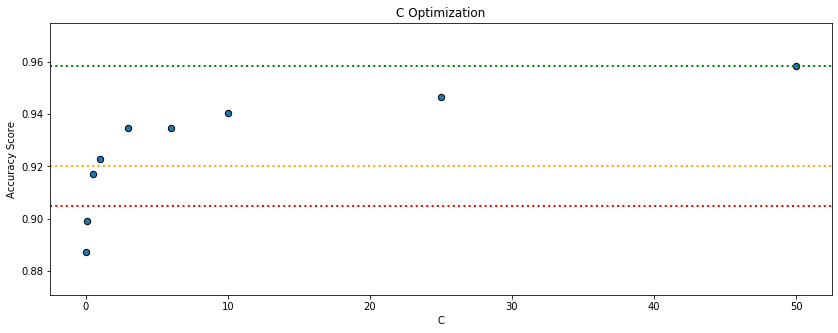

In [7]:
_=plt.figure(figsize=(14,5))
_=plt.scatter(Cs, score_list, edgecolor='k', linewidth=1, s=40)
_=plt.axhline(max(score_list), c='g', linestyle=':', linewidth=2)
_=plt.axhline(.9048, c='r', linestyle=':', linewidth=2)
_=plt.axhline(.92, c='orange', linestyle=':', linewidth=2)
_=plt.xlabel('C')
_=plt.ylabel('Accuracy Score')
_=plt.title('C Optimization')

In [8]:
Cs = [i for i in np.arange(36, 40, .5)]
score_list = []

# Find the best value for the paramater C
score=0
bestC=0
for Cval in Cs:
    clf2=LogisticRegression(C=Cval, solver='lbfgs', max_iter=5000)
    score_temp=cv_score(clf2, X_train.values, y_train.values)
    score_list.append(round(score_temp, 4))
    if score_temp > score:
        bestC=Cval     
        score=round(score_temp, 4)
        print(Cval,' ',score)
print("\nThe best average score is:",score,'with C=',bestC)

36.0   0.9524
36.5   0.9524
37.0   0.9524
37.5   0.9585

The best average score is: 0.9585 with C= 37.5


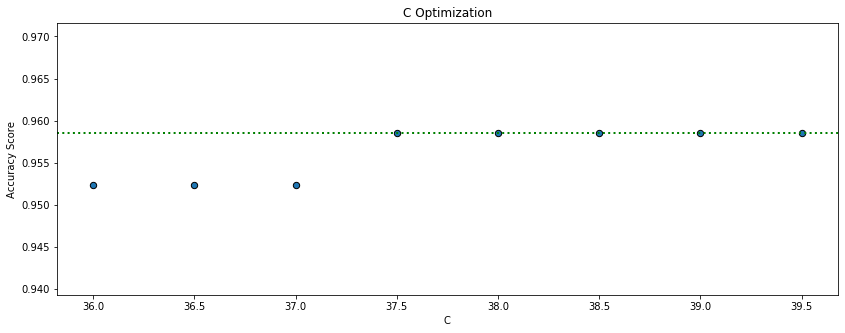

In [9]:
_=plt.figure(figsize=(14,5))
_=plt.scatter(Cs, score_list, edgecolor='k', linewidth=1, s=40)
_=plt.axhline(max(score_list), c='g', linestyle=':', linewidth=2)
_=plt.xlabel('C')
_=plt.ylabel('Accuracy Score')
_=plt.title('C Optimization')

5-fold cross validation along with a proper choice of $C$ shows a good improvement in the accuracy.

The built in function GridSearchCV verifies this, reinforcing the choice of $C=37.5$.

In [10]:
# Using GridSearchCV returns similar results
param_grid={'C':np.arange(30,40,.3)}
clf_cv= GridSearchCV(clf,param_grid,cv=5)
clf_cv.fit(X_train.values, y_train.values)

best_params=clf_cv.best_params_
best_score=clf_cv.best_score_

print('Best is:',best_params,' accuracy score',best_score)

accuracy=accuracy_score(clf_cv.predict(X_test.values),y_test.values)
print('Test set accuracy score:',accuracy)

Best is: {'C': 37.500000000000014}  accuracy score 0.9467023172905525
Test set accuracy score: 0.9523809523809523


#### Penalties

The solver 'lbfgs' supports $L2$ penalties in the LogisticRegression classifier. Below, different solvers and types are tested to find the optimized solver and penalty value combination.

In [11]:
train_score_list = []
test_score_list = []
lst = np.arange(0, 1, .1)
for rat in lst:
    clf3 = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=rat, C=37.5, max_iter=7000)
    clf3.fit(X_train, y_train)
    train_score = clf3.score(X_train, y_train)
    test_score = clf3.score(X_test, y_test)
    train_score_list.append(train_score)
    test_score_list.append(test_score)

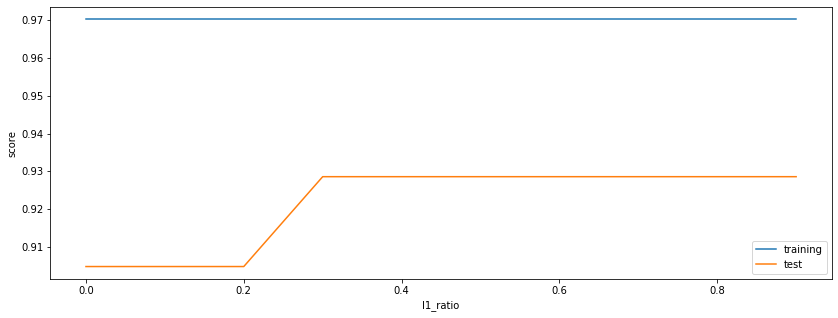

In [12]:
_=plt.figure(figsize=(14,5))
_=plt.plot(lst, train_score_list)
_=plt.plot(lst, test_score_list)
_=plt.legend(['training','test'])
_=plt.xlabel('l1_ratio')
_=plt.ylabel('score')

The saga solver using an elastic net with an l1_ratio of $.3$ yields an improvement on test data.

### Create the final, optimized classifier

In [22]:
# Create the final classifier with C=37.5 and fit it to the test set. Check the score
clf = LogisticRegression(C=37.5, solver='lbfgs', max_iter=5000)

clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
train_score = clf.score(X_train, y_train)

print('\nTraining score:',round(train_score, 4) * 100,'%   Test score:',round(test_score,4) * 100,'%')

# Use cross validation with the optimized values
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# Using 5-Fold Cross Validation in the function cv_score

score = round(cv_score(clf, X_train.values, y_train.values),2)

print('\nAccuracy: ' + str(score * 100) + '%')


Training score: 98.21 %   Test score: 95.24000000000001 %

Accuracy: 96.0%


### Classification Report for Logistic Regression

A more detailed report of performance can be found using scikit-learn's classification report function.

In [23]:
y_pred_train = clf.predict(X_train)

y_pred_test = clf.predict(X_test)

In [15]:
print("\nTraining Classification Report:")
print(classification_report(y_train, y_pred_train))

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))


Training Classification Report:
              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97        59
         2.0       0.98      1.00      0.99        56
         3.0       0.98      0.98      0.98        53

    accuracy                           0.98       168
   macro avg       0.98      0.98      0.98       168
weighted avg       0.98      0.98      0.98       168


Test Classification Report:
              precision    recall  f1-score   support

         1.0       0.85      1.00      0.92        11
         2.0       1.00      1.00      1.00        14
         3.0       1.00      0.88      0.94        17

    accuracy                           0.95        42
   macro avg       0.95      0.96      0.95        42
weighted avg       0.96      0.95      0.95        42



In [16]:
# Create a truth list with the correct names in the test set
y_truth = []
for i in range(len(y_test)):
    y_tru = class_dict[y_test.values[i]]
    y_truth.append(y_tru)

# The list of predicted probabilites for each class in each row of the test set
probabilities = clf.predict_proba(X_test)
probabilities = pd.DataFrame(probabilities.round())
probabilities.columns = ['Kama', 'Rosa', 'Canadian']
probabilities = probabilities == True
probabilities['truth'] = y_truth

probabilities.head()

,Kama,Rosa,Canadian,truth
0,True,False,False,Kama
1,False,False,True,Canadian
2,False,True,False,Rosa
3,True,False,False,Canadian
4,True,False,False,Kama


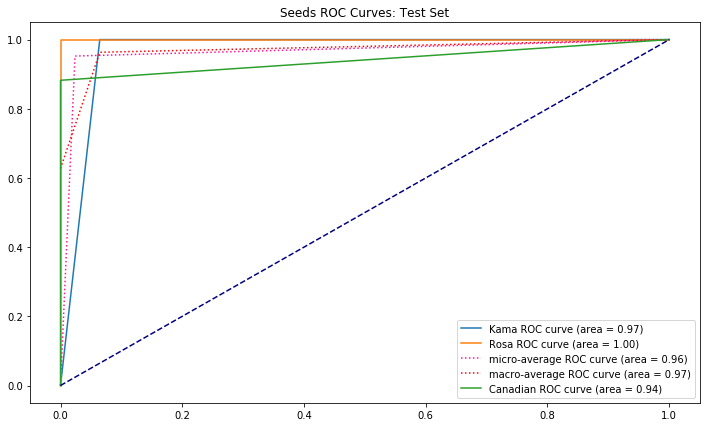

In [51]:
# Calculate the roc curve and auc score for each class
X = seeds.drop('class', axis =1)
y = seeds['class']

# Binarize the predicted classes
y_pred_train_bin = label_binarize(y_pred_train, classes = [1, 2, 3])
y_pred_test_bin = label_binarize(y_pred_test, classes = [1, 2, 3])

# Binarize the training and test original data for comparison
y_train_bin = label_binarize(y_train, classes = [1, 2, 3])
y_test_bin = label_binarize(y_test, classes = [1, 2, 3])

# Set thenumber of classes
num_classes = y_train_bin.shape[1]

# Loop through classes and caclulate roc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_test_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_test_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the curve
plt.figure(figsize = (12, 7))
plt.plot(fpr[0], tpr[0], label = 'Kama ROC curve (area = %.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], label = 'Rosa ROC curve (area = %.2f)' % roc_auc[1])
plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')
plt.plot(fpr['macro'], tpr['macro'], label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='red', linestyle=':')
plt.plot(fpr[2], tpr[2], label = 'Canadian ROC curve (area = %.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Seeds ROC Curves: Test Set')
plt.legend(loc = 'lower right')

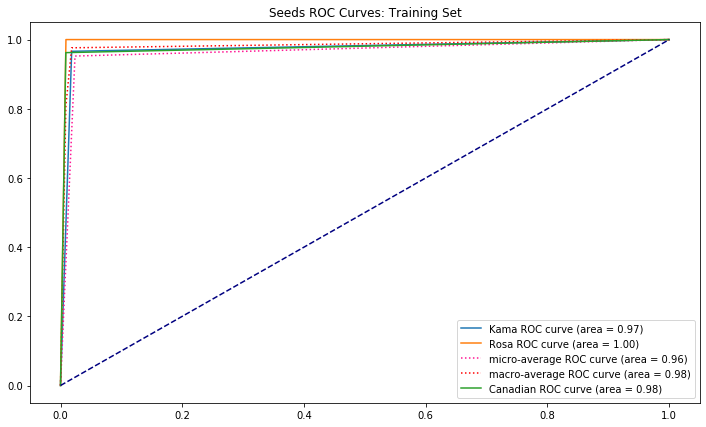

In [52]:
# Calculate ROC for the training data for comparison
# Loop through classes and caclulate roc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_pred_train_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_test_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the curve
plt.figure(figsize = (12, 7))
plt.plot(fpr[0], tpr[0], label = 'Kama ROC curve (area = %.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], label = 'Rosa ROC curve (area = %.2f)' % roc_auc[1])
plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')
plt.plot(fpr['macro'], tpr['macro'], label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='red', linestyle=':')
plt.plot(fpr[2], tpr[2], label = 'Canadian ROC curve (area = %.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Seeds ROC Curves: Training Set')
plt.legend(loc = 'lower right')

In [17]:
# Store the coefficients of the Theta matrix for future use as a dataframe
Theta = pd.DataFrame(clf.coef_)
Theta.head()

,0,1,2,3,4,5,6
0,1.245791,-2.686428,0.291030,8.468200,-0.327264,-0.776273,-7.976226
1,1.660971,1.979029,-0.174374,-7.327236,-0.242170,0.317279,4.563127
2,-2.906762,0.707400,-0.116656,-1.140965,0.569434,0.458995,3.413099


The coefficients of the final matrix are stored in a dataframe called Theta, and ready for use in other applications.

### Naive Bayes 

The data is continuous in each feature, prompting the choice of the GaussianNB classifier.

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(seeds.drop(['class'], axis=1), seeds['class'], 
                                                    test_size=.2, random_state=42)

gNB = GaussianNB()
y_pred = gNB.fit(X_train, y_train).predict(X_test)
results = y_pred == y_test
results[:5]

30      True
172     True
84      True
199    False
60     False
Name: class, dtype: bool

In [7]:
# Print the training score
print('The GaussianNB training score:', round(gNB.score(X_train,y_train), 4))

The GaussianNB training score: 0.9345


In [8]:
# Print the test score
print('The GaussianNB test score:', round(gNB.score(X_test, y_test), 4))

The GaussianNB test score: 0.8571


In [9]:
# Perform cross validation
score = round(cv_score(gNB, X_train.values, y_train.values), 2)

print('\nAccuracy: ' + str(score * 100) + '%')


Accuracy: 92.0%


### Classification Report for Naive Bayes

In [10]:
y_pred_train = gNB.predict(X_train)

y_pred_test = gNB.predict(X_test)

print("\nTraining Classification Report:")
print(classification_report(y_train, y_pred_train))

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))


Training Classification Report:
              precision    recall  f1-score   support

         1.0       0.91      0.86      0.89        59
         2.0       0.95      0.95      0.95        56
         3.0       0.91      0.96      0.94        53

    accuracy                           0.92       168
   macro avg       0.92      0.92      0.92       168
weighted avg       0.92      0.92      0.92       168


Test Classification Report:
              precision    recall  f1-score   support

         1.0       0.67      0.73      0.70        11
         2.0       0.93      0.93      0.93        14
         3.0       0.88      0.82      0.85        17

    accuracy                           0.83        42
   macro avg       0.82      0.83      0.82        42
weighted avg       0.84      0.83      0.84        42



The Gaussian Naive Bayes classifier performs with results that suggest possible overfitting. The discrepancy between training and test scores seen in the Logistic Regression model suggests this as well.  

### Feature Selection

The GaussianNB classification report is very different from that of the previous model. The very high precision and recall scores seen in the LogisticRegression report suggest that some leakage could be occuring between the features, causing such good results. To test this, feature pairs that have been identified as being highly correlated are first checked with one of the features removed from the dataframe. The score is then evaluated to compare against the score with the other feature removed. 

In [11]:
# Remove Asymmetry coefficient from dataframe
X2 = seeds.drop(['asymmetry_coefficient','class'], axis=1)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, seeds['class'], 
                                                    test_size=.2, random_state=42)

# Remove asymmetry coefficient and compactness
X3 = seeds.drop(['asymmetry_coefficient','compactness','class'], axis=1)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, seeds['class'], 
                                                    test_size=.2, random_state=42)

# Remove compactness
X4 = seeds.drop(['compactness','class'], axis=1)

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, seeds['class'], 
                                                    test_size=.2, random_state=42)

In [44]:
# Check score with asymmetry_coefficient removed
clf2 = LogisticRegression(C=37.5, solver='lbfgs', max_iter=5000)

clf2.fit(X2_train, y2_train)

test_score = clf2.score(X2_test, y2_test)
train_score = clf2.score(X2_train, y2_train)

print('\nWith "asymmetry_coefficient" removed-')
print('\nTraining score:',round(train_score, 4) * 100,'%   Test score:',round(test_score,4) * 100,'%')


With "asymmetry_coefficient" removed-

Training score: 97.02 %   Test score: 85.71 %


In [37]:
y_pred_train = clf2.predict(X2_train)

y_pred_test = clf2.predict(X2_test)

print("\nTraining Classification Report with 'asymmetry_coefficient' removed:\n")
print(classification_report(y_train, y_pred_train))

print("\nTest Classification Report with 'asymmetry_coefficient' removed:\n")
print(classification_report(y_test, y_pred_test))


Training Classification Report with 'asymmetry_coefficient' removed:

              precision    recall  f1-score   support

         1.0       0.97      0.95      0.96        59
         2.0       0.98      1.00      0.99        56
         3.0       0.96      0.96      0.96        53

    accuracy                           0.97       168
   macro avg       0.97      0.97      0.97       168
weighted avg       0.97      0.97      0.97       168


Test Classification Report with 'asymmetry_coefficient' removed:

              precision    recall  f1-score   support

         1.0       0.67      0.91      0.77        11
         2.0       1.00      0.93      0.96        14
         3.0       0.93      0.76      0.84        17

    accuracy                           0.86        42
   macro avg       0.87      0.87      0.86        42
weighted avg       0.88      0.86      0.86        42



In [45]:
# Check score with asymmetry_coefficient & compactness removed
clf3 = LogisticRegression(C=37.5, solver='lbfgs', max_iter=5000)
clf3.fit(X3_train, y3_train)

test_score = clf3.score(X3_test, y3_test)
train_score = clf3.score(X3_train, y3_train)

print('\nWith "asymmetry_coefficient" and "compactness" removed-')
print('\nTraining score:',round(train_score, 4) * 100,'%   Test score:',round(test_score,4) * 100,'%')


With "asymmetry_coefficient" and "compactness" removed-

Training score: 97.02 %   Test score: 85.71 %


In [39]:
y3_pred_train = clf3.predict(X3_train)

y3_pred_test = clf3.predict(X3_test)

print("\nTraining Classification Report with 'asymmetry_coefficient' and 'compactness' removed:\n")
print(classification_report(y3_train, y3_pred_train))

print("\nTest Classification Report with 'asymmetry_coefficient' and 'compactness' removed:\n")
print(classification_report(y3_test, y3_pred_test))


Training Classification Report with 'asymmetry_coefficient' and 'compactness' removed:

              precision    recall  f1-score   support

         1.0       0.97      0.95      0.96        59
         2.0       0.98      1.00      0.99        56
         3.0       0.96      0.96      0.96        53

    accuracy                           0.97       168
   macro avg       0.97      0.97      0.97       168
weighted avg       0.97      0.97      0.97       168


Test Classification Report with 'asymmetry_coefficient' and 'compactness' removed:

              precision    recall  f1-score   support

         1.0       0.67      0.91      0.77        11
         2.0       1.00      0.93      0.96        14
         3.0       0.93      0.76      0.84        17

    accuracy                           0.86        42
   macro avg       0.87      0.87      0.86        42
weighted avg       0.88      0.86      0.86        42



In [13]:
# Check score with compactness removed
clf4 = LogisticRegression(C=37.5, solver='lbfgs', max_iter=5000)
clf4.fit(X4_train, y4_train)

test_score = clf4.score(X4_test, y4_test)
train_score = clf4.score(X4_train, y4_train)

print('\nWith "compactness" removed-')
print('\nTraining score:',round(train_score, 4) * 100,'%   Test score:',round(test_score,4) * 100,'%')

score = round(cv_score(clf, X_train.values, y_train.values),2)

print('\nCV accuracy: ' + str(score * 100) + '%')


With "compactness" removed-

Training score: 98.21 %   Test score: 95.24000000000001 %

CV accuracy: 96.0%


In [40]:
y4_pred_train = clf4.predict(X4_train)

y4_pred_test = clf4.predict(X4_test)

print("\nTraining Classification Report with 'compactness' removed:\n")
print(classification_report(y4_train, y4_pred_train))

print("\nTest Classification Report with 'compactness' removed:\n")
print(classification_report(y4_test, y4_pred_test))


Training Classification Report with 'compactness' removed:

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97        59
         2.0       0.98      1.00      0.99        56
         3.0       0.98      0.98      0.98        53

    accuracy                           0.98       168
   macro avg       0.98      0.98      0.98       168
weighted avg       0.98      0.98      0.98       168


Test Classification Report with 'compactness' removed:

              precision    recall  f1-score   support

         1.0       0.85      1.00      0.92        11
         2.0       1.00      1.00      1.00        14
         3.0       1.00      0.88      0.94        17

    accuracy                           0.95        42
   macro avg       0.95      0.96      0.95        42
weighted avg       0.96      0.95      0.95        42



## Next Steps

The logistic regression model performs well, with accuracy scores reaching greater than $95\%$. Removing the 'compactness' column from the dataframe seems to keep performance while having a more realistic classificaiton report. 

Using the 'lbfgs' solver gave the best results. Optimizing the hyperparameter $C$ for tuning regularization reduces overfitting. The test scores are improved, closing the gap between training and test error. A naive Bayes approach did not perform as well as logistic regression. 

Next, unsupervised clustering algorithms will be evaluated, such as K-means. Finally, we will build a neural network model and compare its performance to the previous models.